In [4]:
#%pip install pandas_gbq

In [6]:
import pandas_gbq
import pandas     as pd
import numpy      as np
import sklearn    as sk
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import warnings
import seaborn as sn
import matplotlib
warnings.filterwarnings('ignore')
feature_names = ['gps_speed' , 'battery' , 'cTemp' , 'eLoad' , 'iat' , 'imap' , 'kpl' , 'maf' , 'rpm' , 'speed' , 'tAdv' , 'tPos']

In [7]:
def compute_window(data):
    temp1 = data[['date' , 'vin' , 'dtc']]
    temp2 = temp1
    joined_df = pd.merge(temp1,temp2,on=['vin'])
    joined_df = joined_df[joined_df.date_x <= joined_df.date_y]
    joined_df = joined_df[joined_df.date_x >= (joined_df.date_y - pd.DateOffset(days=3))]
    joined_df = joined_df[['date_x', 'vin' , 'dtc_y']]
    joined_df = joined_df.groupby(by=['date_x', 'vin']).max().reset_index()
    joined_df.rename(columns={'date_x': 'date', 'dtc_y': 'dtc'}, inplace=True)
    datamerged = pd.merge (data,joined_df , on=['vin' , 'date'])
    datamerged = datamerged.drop(['dtc_x'], axis=1)
    datamerged.rename(columns={'dtc_y': 'dtc'}, inplace=True)
    return datamerged

In [8]:
def prepare_data(data):
    
    data['dtc'] = data['dtc'].astype(int)
    data = compute_window(data)
    X = data[feature_names].values
    Y = data['dtc'].values
    return X,Y

In [9]:
def model_fit(trainX, trainY , testX, testY , modelType):   
    if modelType == 'LDA':
        clf = LinearDiscriminantAnalysis().fit(trainX, trainY)
        print("\033[1m" + "LDA Model" + "\033[0m")
    elif modelType == 'DT':
        clf = DecisionTreeClassifier().fit(trainX, trainY)
        print("\033[1m" + "Decision Tree Model" + "\033[0m")
    elif modelType == 'GNB':  
        clf = GaussianNB().fit(trainX, trainY)
        print("\033[1m" + "Gaussian Naive Bayes Model:" + "\033[0m")
    elif modelType == 'SVM':  
        clf = SVC().fit(trainX, trainY)
        print("\033[1m" + "Support Vector Machines Model:" + "\033[0m")    
             
    print('Accuracy on training set: {:.2f}'
         .format(clf.score(trainX, trainY)))
    print('Accuracy on test set: {:.2f}'
         .format(clf.score(testX, testY)))
    pred = clf.predict(testX)
    #print ("Confusion Matrix :")
    #print(confusion_matrix(testY, pred))
    print ("\033[1m" + "Classification Report : " + "\033[0m")
    print(classification_report(testY, pred))
    print ("\033[1m" + "Confusion Matrix :"  + "\033[0m")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plot_confusion_matrix(clf, testX, testY , cmap=plt.cm.Blues )
    plt.show()
    return clf

In [10]:
def feature_analysis(data):
    corrMatrix = data[feature_names].astype(int).corr()
    sn.heatmap(corrMatrix, annot=True , cmap="YlGnBu")
    print ("\033[1m" + "Correlation Report for independent variables : " + "\033[0m")
    plt.show()

In [11]:
get_ipython().run_cell_magic('bigquery', 'trainData', 'SELECT * FROM `data-demo-2021.autorepair.autotelemetry_train`')


Downloading: 100%|██████████| 24512/24512 [00:01<00:00, 20957.95rows/s]


In [12]:
get_ipython().run_cell_magic('bigquery', 'testData', 'SELECT * FROM `data-demo-2021.autorepair.autotelemetry_test`')


Downloading: 100%|██████████| 15744/15744 [00:01<00:00, 14475.49rows/s]


Correlation Report for independent variables : 


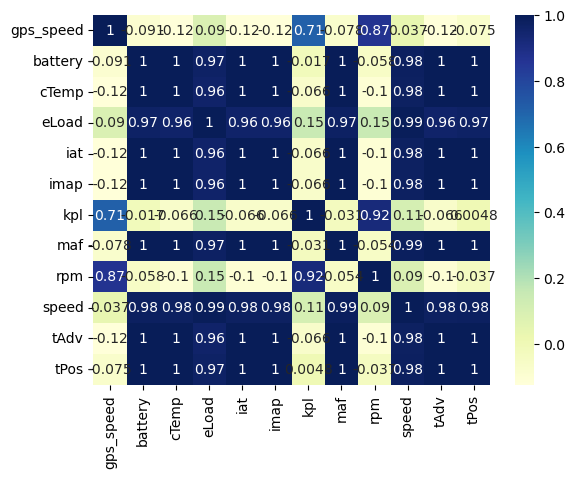

In [22]:
feature_analysis(trainData)

Gaussian Naive Bayes Model:
Accuracy on training set: 0.94
Accuracy on test set: 0.94
Classification Report : 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20480
           1       0.90      1.00      0.95      1728
           2       1.00      0.33      0.50      2304

    accuracy                           0.94     24512
   macro avg       0.95      0.78      0.81     24512
weighted avg       0.94      0.94      0.92     24512

Confusion Matrix :


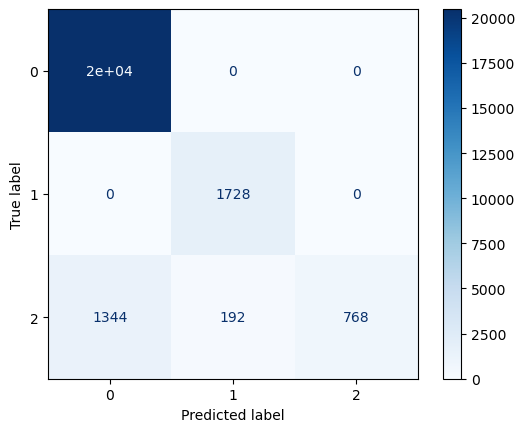

In [23]:
trainX,trainY = prepare_data(trainData)
testX,testY = prepare_data(trainData)
clf = model_fit(trainX, trainY , testX, testY , 'GNB')

In [24]:
get_ipython().run_cell_magic('bigquery', 'predictData', 'SELECT * FROM `data-demo-2021.autorepair.autotelemetry_predict`')

Downloading: 100%|██████████| 22080/22080 [00:01<00:00, 18286.42rows/s]


In [25]:
predictX,predictY = prepare_data(predictData)
output = predictData.iloc[:, predictData.columns != 'dtc']
output = output[['vin' , 'date']]
output['dtcPredicted'] = clf.predict(predictX)
output.to_gbq('autorepair.predict_results', project_id='data-demo-2021',if_exists='replace')

1it [00:04,  4.98s/it]


In [26]:
np.unique(clf.predict(predictX))

array([0, 1, 2])